<a href="https://colab.research.google.com/github/SHIVADHARSHINI25/HTMLActorPage/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# Mount Google Drive if your dataset is stored there
from google.colab import drive
drive.mount('/content/drive')

# Navigate to your dataset folder
import os
os.chdir('/content/drive/MyDrive/CrowdDataset')  # Change path accordingly


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os


In [ ]:


# Step 2: Check inside your dataset folder
!ls /content/drive/MyDrive/CrowdDataset


test  train  val


In [22]:
!ls /content/drive/MyDrive/CrowdDataset/test



growth_truth  images


In [ ]:
!ls /content/drive/MyDrive/CrowdDataset/train/ground_truth | head -10



GT_IMG_61.mat
GT_IMG_62.mat
GT_IMG_63.mat
GT_IMG_64.mat
GT_IMG_65.mat
GT_IMG_66.mat
GT_IMG_67.mat
GT_IMG_68.mat
GT_IMG_69.mat
GT_IMG_70.mat


In [ ]:
import scipy.io
import os, cv2
import numpy as np

IMG_SIZE = 128  # Resize images for CNN

def load_data(img_dir, gt_dir, limit=None):
    X, y = [], []
    img_files = sorted(os.listdir(img_dir))

    if limit:
        img_files = img_files[:limit]

    for img_name in img_files:
        img_path = os.path.join(img_dir, img_name)
        gt_name  = "GT_" + img_name.replace('.jpg', '.mat')  # ✅ add GT_ prefix
        gt_path  = os.path.join(gt_dir, gt_name)

        # Load and preprocess image
        img = cv2.imread(img_path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0
        X.append(img)

        # Load ground truth (.mat file)
        mat = scipy.io.loadmat(gt_path)
        points = mat["image_info"][0,0][0,0][0]   # ShanghaiTech format
        count = points.shape[0]   # number of heads
        y.append(count)

    return np.array(X), np.array(y)

# ✅ Load TRAIN data
train_img_dir = "/content/drive/MyDrive/CrowdDataset/train/images"
train_gt_dir  = "/content/drive/MyDrive/CrowdDataset/train/ground_truth"

X_train, y_train = load_data(train_img_dir, train_gt_dir, limit=200)
print("Train data shape:", X_train.shape, y_train.shape)
print("Sample counts:", y_train[:10])


Train data shape: (21, 128, 128, 3) (21,)
Sample counts: [ 88 643 241 212 427 850 163 199 367 418]


In [24]:
import scipy.io
import os, cv2
import numpy as np

IMG_SIZE = 128  # Resize images for CNN

def load_data(img_dir, gt_dir, limit=None):
    X, y = [], []
    img_files = sorted(os.listdir(img_dir))

    if limit:
        img_files = img_files[:limit]

    for img_name in img_files:
        img_path = os.path.join(img_dir, img_name)
        gt_name  = "GT_" + img_name.replace('.jpg', '.mat')  # ✅ add GT_ prefix
        gt_path  = os.path.join(gt_dir, gt_name)

        # Load and preprocess image
        img = cv2.imread(img_path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0
        X.append(img)

        # Load ground truth (.mat file)
        mat = scipy.io.loadmat(gt_path)
        points = mat["image_info"][0,0][0,0][0]   # ShanghaiTech format
        count = points.shape[0]   # number of heads
        y.append(count)

    return np.array(X), np.array(y)


# ✅ TRAIN data
train_img_dir = "/content/drive/MyDrive/CrowdDataset/train/images"
train_gt_dir  = "/content/drive/MyDrive/CrowdDataset/train/ground_truth"

X_train, y_train = load_data(train_img_dir, train_gt_dir, limit=200)
print("Train data shape:", X_train.shape, y_train.shape)
print("Sample train counts:", y_train[:10])


# ✅ VAL data
val_img_dir = "/content/drive/MyDrive/CrowdDataset/val/images"
val_gt_dir  = "/content/drive/MyDrive/CrowdDataset/val/ground_truth"

X_val, y_val = load_data(val_img_dir, val_gt_dir, limit=50)
print("Val data shape:", X_val.shape, y_val.shape)
print("Sample val counts:", y_val[:10])


# ✅ TEST data
test_img_dir = "/content/drive/MyDrive/CrowdDataset/test/images"
test_gt_dir  = "/content/drive/MyDrive/CrowdDataset/test/growth_truth"

X_test, y_test = load_data(test_img_dir, test_gt_dir, limit=50)
print("Test data shape:", X_test.shape, y_test.shape)
print("Sample test counts:", y_test[:10])


Train data shape: (21, 128, 128, 3) (21,)
Sample train counts: [ 88 643 241 212 427 850 163 199 367 418]
Val data shape: (21, 128, 128, 3) (21,)
Sample val counts: [ 88 643 241 212 427 850 163 199 367 418]
Test data shape: (21, 128, 128, 3) (21,)
Sample test counts: [236 249 797 116 366 138 373 316 384 511]


In [25]:
import tensorflow as tf
from tensorflow.keras import layers, models

# CNN Model for Crowd Counting
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)   # Regression (predict count)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=4,
    verbose=1
)

# Evaluate
test_loss, test_mae = model.evaluate(X_test, y_test)
print("✅ Test MAE:", test_mae)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - loss: 248059.7344 - mae: 357.0948 - val_loss: 342632.5312 - val_mae: 421.2528
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - loss: 323954.2188 - mae: 416.9854 - val_loss: 329742.2500 - val_mae: 405.6624
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - loss: 363586.6250 - mae: 417.2907 - val_loss: 292925.8125 - val_mae: 357.0663
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - loss: 190743.2188 - mae: 287.3695 - val_loss: 214841.0312 - val_mae: 239.7491
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - loss: 107392.5781 - mae: 189.2816 - val_loss: 173614.2656 - val_mae: 268.1887
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - loss: 106232.6016 - mae: 232.8518 - val_loss: 175793.2812 - val_mae: 276.5741
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - loss: 208079.7344 - mae: 292.9592 - val_loss: 171439.5781 - val_mae: 255.8782
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - loss: 125716.1953 - mae: 226.5829 - va

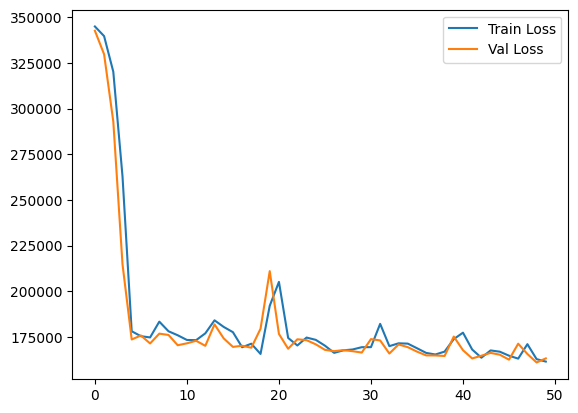

In [26]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()


In [28]:
# Pick first test image
test_img = X_test[0].reshape(1, IMG_SIZE, IMG_SIZE, 3)

# Predict
pred_count = model.predict(test_img)[0][0]
print("Predicted Count:", round(pred_count))
print("Ground Truth Count:", y_test[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Predicted Count: 384
Ground Truth Count: 236


In [30]:
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
print("Test MSE (Loss):", test_loss)
print("Test MAE:", test_mae)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 54105.0117 - mae: 171.7775
Test MSE (Loss): 54105.01171875
Test MAE: 171.77749633789062


In [31]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Predictions
y_pred = model.predict(X_test).flatten()

# RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# R^2 Score
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R² Score:", r2)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
RMSE: 232.6048402736925
R² Score: -0.18027591705322266


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


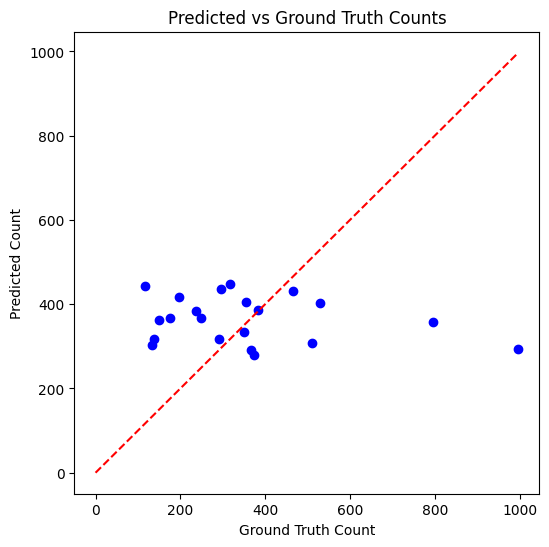

Test MAE: 171.77749633789062


In [32]:
from sklearn.metrics import mean_absolute_error

# Predictions
y_pred = model.predict(X_test).flatten()

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--')  # ideal y=x line
plt.xlabel("Ground Truth Count")
plt.ylabel("Predicted Count")
plt.title("Predicted vs Ground Truth Counts")
plt.show()

mae = mean_absolute_error(y_test, y_pred)
print("Test MAE:", mae)


In [29]:
y_pred = model.predict(X_test).flatten()

for i in range(5):  # check first 5 samples
    print(f"Image {i+1} -> GT: {y_test[i]}, Pred: {round(y_pred[i])}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
Image 1 -> GT: 236, Pred: 384
Image 2 -> GT: 249, Pred: 366
Image 3 -> GT: 797, Pred: 359
Image 4 -> GT: 116, Pred: 444
Image 5 -> GT: 366, Pred: 291


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import gaussian_filter
from scipy.ndimage import maximum_filter
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
import os
from PIL import Image
import torch
import torchvision.transforms as transforms
from google.colab.patches import cv2_imshow

class CrowdDensityVisualizer:
    def __init__(self):
        # Create custom colormap similar to your reference image
        colors = ['#000080', '#0080FF', '#00FF80', '#FFFF00', '#FF8000', '#FF0000']
        n_bins = 256
        self.density_cmap = LinearSegmentedColormap.from_list('density', colors, N=n_bins)

    def create_density_map_from_points(self, image_shape, points, sigma=20):
        """
        Create density map from point annotations
        Args:
            image_shape: (H, W) tuple
            points: List of (x, y) coordinates
            sigma: Gaussian kernel sigma
        """
        h, w = image_shape
        density_map = np.zeros((h, w), dtype=np.float32)

        for point in points:
            x, y = int(point[0]), int(point[1])
            if 0 <= x < w and 0 <= y < h:
                density_map[y, x] = 1.0

        # Apply Gaussian filter
        density_map = gaussian_filter(density_map, sigma=sigma)
        return density_map

    def create_density_map_from_prediction(self, predicted_density):
        """
        Process model prediction to create visualization-ready density map
        Args:
            predicted_density: Model output (numpy array or tensor)
        """
        if torch.is_tensor(predicted_density):
            predicted_density = predicted_density.detach().cpu().numpy()

        # Normalize density map
        if predicted_density.max() > 0:
            predicted_density = predicted_density / predicted_density.max()

        return predicted_density

    def visualize_density_comparison(self, images, ground_truth_counts, predicted_counts,
                                   density_maps=None, save_path=None, figsize=(20, 12)):
        """
        Create comparison visualization like your reference image
        Args:
            images: List of images (numpy arrays)
            ground_truth_counts: List of ground truth counts
            predicted_counts: List of predicted counts
            density_maps: List of density maps (optional)
            save_path: Path to save the figure
        """
        n_images = len(images)
        fig, axes = plt.subplots(2, n_images, figsize=figsize)

        if n_images == 1:
            axes = axes.reshape(2, 1)

        for i in range(n_images):
            # Original image with count information
            axes[0, i].imshow(images[i])
            axes[0, i].set_title(f'GT: {ground_truth_counts[i]}, Pred: {predicted_counts[i]}',
                               fontsize=12, fontweight='bold', color='white',
                               bbox=dict(boxstyle="round,pad=0.3", facecolor='black', alpha=0.7))
            axes[0, i].axis('off')

            # Density map
            if density_maps is not None and i < len(density_maps):
                density_map = density_maps[i]
            else:
                # Generate sample density map if not provided
                density_map = self._generate_sample_density_map(images[i].shape[:2], predicted_counts[i])

            im = axes[1, i].imshow(density_map, cmap=self.density_cmap, alpha=0.8)
            axes[1, i].imshow(images[i], alpha=0.3)  # Overlay original image with transparency

            # Add count information
            estimated_count = int(np.sum(density_map) * 100)  # Scale factor for visualization
            axes[1, i].set_title(f'Est Count: {estimated_count}',
                               fontsize=12, fontweight='bold', color='white',
                               bbox=dict(boxstyle="round,pad=0.3", facecolor='blue', alpha=0.7))
            axes[1, i].axis('off')

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='black')

        plt.show()

    def create_single_density_visualization(self, image, density_map, gt_count, pred_count,
                                          title="Crowd Density Analysis", save_path=None):
        """
        Create a single image density visualization
        """
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        fig.patch.set_facecolor('black')

        # Original image
        axes[0].imshow(image)
        axes[0].set_title(f'Original Image\nGT: {gt_count}, Pred: {pred_count}',
                         fontsize=14, fontweight='bold', color='white')
        axes[0].axis('off')

        # Density map overlay
        axes[1].imshow(image, alpha=0.4)
        im = axes[1].imshow(density_map, cmap=self.density_cmap, alpha=0.8)

        # Add colorbar
        cbar = plt.colorbar(im, ax=axes[1], shrink=0.8)
        cbar.set_label('Density Level', color='white', fontsize=12)
        cbar.ax.yaxis.set_tick_params(color='white')
        plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')

        estimated_count = int(np.sum(density_map) * 100)
        axes[1].set_title(f'Density Map\nEstimated Count: {estimated_count}',
                         fontsize=14, fontweight='bold', color='white')
        axes[1].axis('off')

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='black')

        plt.show()

    def create_grid_visualization(self, images, density_maps, gt_counts, pred_counts,
                                grid_size=(2, 3), save_path=None):
        """
        Create a grid layout similar to your reference image
        """
        rows, cols = grid_size
        fig, axes = plt.subplots(rows, cols, figsize=(20, 12))
        fig.patch.set_facecolor('navy')

        if rows == 1:
            axes = axes.reshape(1, -1)

        for i in range(min(len(images), rows * cols)):
            row = i // cols
            col = i % cols

            # Create density overlay
            axes[row, col].imshow(images[i], alpha=0.5)
            im = axes[row, col].imshow(density_maps[i], cmap=self.density_cmap, alpha=0.9)

            # Add count text
            axes[row, col].text(10, 30, f'GT: {gt_counts[i]}',
                              fontsize=12, fontweight='bold', color='white',
                              bbox=dict(boxstyle="round,pad=0.3", facecolor='black', alpha=0.7))
            axes[row, col].text(10, 60, f'Pred: {pred_counts[i]}',
                              fontsize=12, fontweight='bold', color='white',
                              bbox=dict(boxstyle="round,pad=0.3", facecolor='blue', alpha=0.7))

            axes[row, col].axis('off')

        # Hide empty subplots
        for i in range(len(images), rows * cols):
            row = i // cols
            col = i % cols
            axes[row, col].axis('off')

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='navy')

        plt.show()

    def _generate_sample_density_map(self, image_shape, count_estimate):
        """Generate sample density map for demonstration"""
        h, w = image_shape
        density_map = np.zeros((h, w))

        # Create random hotspots based on count estimate
        n_hotspots = max(1, count_estimate // 50)

        for _ in range(n_hotspots):
            center_x = np.random.randint(w//4, 3*w//4)
            center_y = np.random.randint(h//4, 3*h//4)

            # Create Gaussian hotspot
            y, x = np.ogrid[:h, :w]
            mask = (x - center_x)**2 + (y - center_y)**2 <= (min(h, w)//8)**2
            density_map[mask] += np.random.random() * 0.8

        # Apply Gaussian smoothing
        density_map = gaussian_filter(density_map, sigma=20)

        # Normalize
        if density_map.max() > 0:
            density_map = density_map / density_map.max()

        return density_map

# Example usage functions for your model integration

def integrate_with_your_model(model, image_paths, device='cuda'):
    """
    Example function to integrate with your existing crowd counting model
    """
    visualizer = CrowdDensityVisualizer()

    images = []
    density_maps = []
    gt_counts = []
    pred_counts = []

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    model.eval()
    with torch.no_grad():
        for img_path in image_paths:
            # Load image
            image = cv2.imread(img_path)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Prepare for model
            input_tensor = transform(Image.fromarray(image_rgb)).unsqueeze(0).to(device)

            # Get model prediction
            prediction = model(input_tensor)  # Adjust based on your model output

            # Process density map
            if isinstance(prediction, tuple):
                density_pred = prediction[0]  # Adjust based on your model structure
            else:
                density_pred = prediction

            density_map = visualizer.create_density_map_from_prediction(density_pred.squeeze())

            # Resize density map to match original image
            density_map_resized = cv2.resize(density_map, (image_rgb.shape[1], image_rgb.shape[0]))

            # Calculate counts
            pred_count = int(np.sum(density_pred.cpu().numpy()))
            gt_count = get_ground_truth_count(img_path)  # Implement this function

            images.append(image_rgb)
            density_maps.append(density_map_resized)
            gt_counts.append(gt_count)
            pred_counts.append(pred_count)

    return images, density_maps, gt_counts, pred_counts, visualizer

def get_ground_truth_count(img_path):
    """
    Extract ground truth count from filename or annotation file
    Implement this based on your dataset structure
    """
    # Example: if GT is in filename like "IMG_001_GT_234.jpg"
    import re
    match = re.search(r'GT_(\d+)', os.path.basename(img_path))
    if match:
        return int(match.group(1))
    return 0

# Demo function with sample data
def demo_visualization():
    """Demo function to show how the visualizer works"""
    visualizer = CrowdDensityVisualizer()

    # Create sample data
    sample_images = []
    sample_density_maps = []
    sample_gt_counts = [236, 249, 797, 116, 366, 138]
    sample_pred_counts = [384, 366, 358, 444, 291, 317]

    # Generate sample images and density maps
    for i in range(6):
        # Create sample image (replace with your actual images)
        img = np.random.randint(0, 255, (300, 400, 3), dtype=np.uint8)
        # Add some structure to make it look more like a crowd scene
        img = gaussian_filter(img, sigma=1.5)

        # Generate density map
        density_map = visualizer._generate_sample_density_map(
            img.shape[:2], sample_pred_counts[i]
        )

        sample_images.append(img)
        sample_density_maps.append(density_map)

    # Create grid visualization
    visualizer.create_grid_visualization(
        sample_images, sample_density_maps,
        sample_gt_counts, sample_pred_counts,
        grid_size=(2, 3), save_path='crowd_analysis_grid.png'
    )

    # Create comparison visualization
    visualizer.visualize_density_comparison(
        sample_images[:3], sample_gt_counts[:3], sample_pred_counts[:3],
        sample_density_maps[:3], save_path='crowd_comparison.png'
    )

# Run the demo
if __name__ == "__main__":
    demo_visualization()

# Instructions for integration with your model:
"""
1. Replace the demo_visualization() with your actual data
2. Use integrate_with_your_model() function with your trained model
3. Modify the density map processing based on your model's output format
4. Adjust the colormap and styling as needed

Example usage:
```python
# Load your model
model = YourCrowdCountingModel()
model.load_state_dict(torch.load('your_model.pth'))

# Get your image paths
image_paths = ['path1.jpg', 'path2.jpg', 'path3.jpg']

# Generate visualizations
images, density_maps, gt_counts, pred_counts, visualizer = integrate_with_your_model(
    model, image_paths, device='cuda'
)

# Create visualizations
visualizer.create_grid_visualization(images, density_maps, gt_counts, pred_counts)
```
"""